In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import altair as alt
from scipy.spatial.distance import squareform, pdist
from scipy import stats
import calendar
from haversine import haversine
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [335]:
# loading dataset
df = pd.read_csv("edinburgh_bikes.csv")

## Data exploration and cleaning


In [336]:
# df.head()
# df.info()
# df.isna().sum() 
# condition = df.isna().any(axis=1) 
# df[condition] # important values are not None
df.drop(["start_station_description", "end_station_description", "index", "start_station_id", "end_station_id", "ended_at"], axis = 1, inplace = True) # Nonrelevant columns to my analysis at the moment

In [337]:
df["started_at"] = pd.to_datetime(df["started_at"]).dt.date.astype("datetime64") # converting from object to date

df.rename(columns = {"started_at" : "date", "duration" : "rental_period"}, inplace = True)

# df["rental_period"] = pd.to_timedelta(df["rental_period"], "seconds") # converting from seconds to day/hour/second format (if needed)

## Lists of active and inactive start stations in last month

In [338]:
df.groupby("date")["rental_period"].count().tail() # detection of last dates in df
help_condition = ((df["date"] >= "2021-06-01") & (df["date"] <= "2021-06-30"))

active_start_stations = df[help_condition]["start_station_name"].unique().tolist() 
active_end_stations = df[help_condition]["end_station_name"].unique().tolist()

# check - inactive start station is also not active as end station
set(active_start_stations).symmetric_difference(set(active_end_stations))

df = df.assign(station_status = np.where((df.start_station_name.isin(active_start_stations)) & (df.end_station_name.isin(active_end_stations)), "active", "inactive"))

inactive_stations = df[df["station_status"] == "inactive"]["start_station_name"].unique().tolist()

## Rentals and returns per active station

In [339]:
condition = df["station_status"] == "active"
df_active = df[condition]
# df_active.groupby("date").count() - 1220 days in df

df_rentals_per_station = df_active.groupby("start_station_name")[["rental_period"]].count().reset_index().rename(columns = {"start_station_name" : "station_name", "rental_period" : "num_of_rentals"})
df_returns_per_station = df_active.groupby("end_station_name")[["rental_period"]].count().reset_index().rename(columns = {"end_station_name" : "station_name", "rental_period" : "num_of_returns"})

# df1 = df_active.groupby("start_station_name")[["rental_period"]].sum().reset_index().set_index("start_station_name")

df_mobility = df_rentals_per_station.merge(df_returns_per_station).sort_values("num_of_rentals", ascending = False)

df_mobility["num_of_rentals_per_day"] = (df_mobility["num_of_rentals"] / 1220).round(2) # mean per day during 2018 - 2021
df_mobility["num_of_returns_per_day"] = (df_mobility["num_of_returns"] / 1220).round(2)
df_mobility["bike_mobility_per_day"] = (df_mobility["num_of_rentals_per_day"] - df_mobility["num_of_returns_per_day"]).round(2)

# Per station and day on average merely more then 3 bikes are rented / returned

fig = px.bar(
    data_frame = df_mobility,
    x = "station_name",
    y = ["num_of_rentals_per_day","num_of_returns_per_day"],
    opacity = 0.8,
    orientation = "v",
    barmode = 'group',
    title='Rentals and returns per station and day',
    labels ={"station_name" : "Station name", "value" : "Bike rented / returned"}
)

fig.update_xaxes(tickangle=45)
fig.show()

# Chart is interactive, can be zoomed in

## Identification of the busiest stations (in observed timespan)

In [340]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df_mobility["station_name"], 
    y = df_mobility["num_of_rentals"], 
    marker_color="blue", 
    name = "rentals"))
                     
fig.add_trace(go.Bar(
    x=df_mobility["station_name"], 
    y = df_mobility["num_of_returns"], 
    marker_color="green", 
    name = "returns"))                     
            
fig.update_layout(
    title='Rentals and returns per station',
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Total',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=1,
        y=0.5,
    ),
    barmode='group',
    bargap=0.15, 
    bargroupgap=0.1 
)
fig.show()

# Chart is interactive, can be zoomed in

In [341]:
# Alternative in altair (only bike rentals, without returns)

alt.Chart(df_mobility).mark_bar(opacity=0.6).encode(
    y = alt.Y(
        "station_name", 
        sort = '-x',
        axis=alt.Axis(title = "Station name")),
    x = alt.X(
        "num_of_rentals",
        axis=alt.Axis(title ="Bike rentals during 2018 - 2021")),
    color = "station_name" 
)

alt.Chart(...)

## Bike overflow vs shortage per station in time

In [342]:
df_mobility = df_mobility.assign(bike_mobility = df_mobility["num_of_rentals"] - df_mobility["num_of_returns"]).sort_values("bike_mobility", ascending = False)

df_mobility

,station_name,num_of_rentals,num_of_returns,num_of_rentals_per_day,num_of_returns_per_day,bike_mobility_per_day,bike_mobility
3,Bristo Square,11338,7090,9.29,5.81,3.48,4248
64,Pollock Halls,9020,6263,7.39,5.13,2.26,2757
73,St Andrew Square,10092,7465,8.27,6.12,2.15,2627
12,City Chambers,5021,2458,4.12,2.01,2.11,2563
5,Bruntsfield Links,6811,4305,5.58,3.53,2.05,2506
...,...,...,...,...,...,...,...
6,Canonmills,7544,10254,6.18,8.40,-2.22,-2710
48,Leith Walk,6861,10033,5.62,8.22,-2.60,-3172
20,Duke Street,6693,10618,5.49,8.70,-3.21,-3925
79,Victoria Quay,9162,13507,7.51,11.07,-3.56,-4345


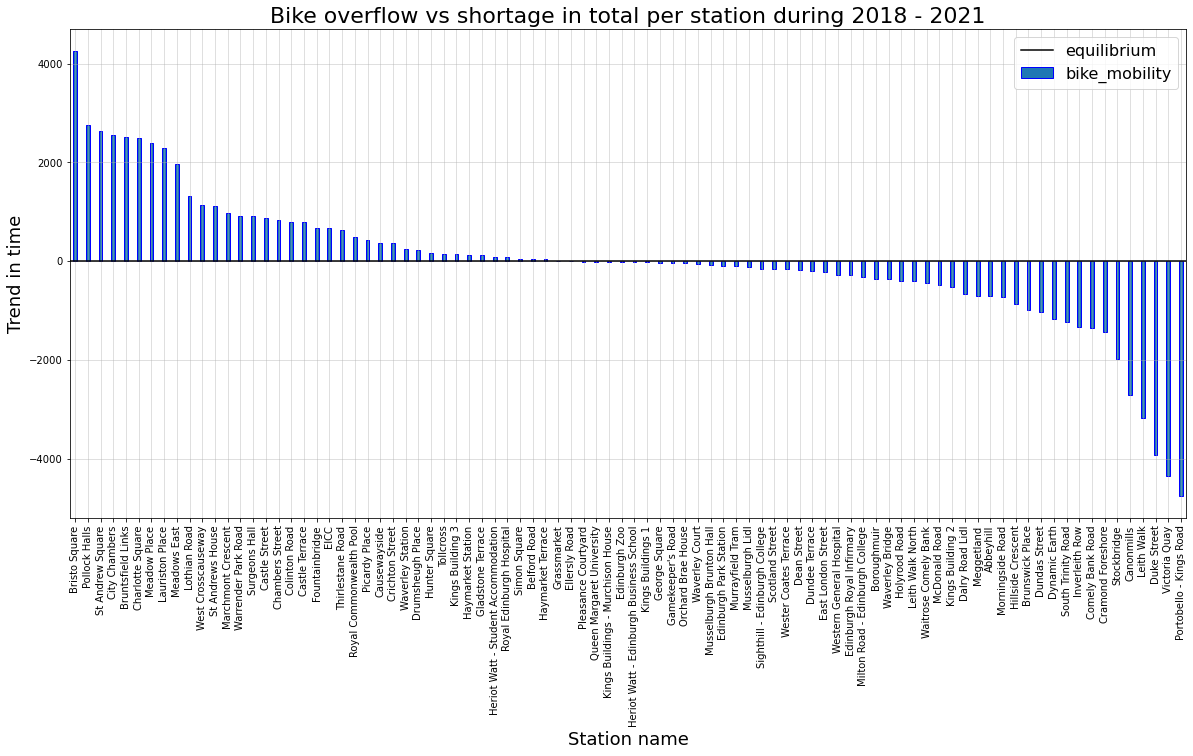

In [343]:
# Visualisation of bike mobility (overflow vs shortage) in the observed period (2018 - 2021)

fig, ax = plt.subplots(figsize = (20,9))
df_mobility.set_index("station_name")["bike_mobility"].plot.bar(
    ax = ax, 
    edgecolor = "blue",
    linewidth=1,
    width=0.3
    )

ax.set_title("Bike overflow vs shortage in total per station during 2018 - 2021", fontsize=22)
ax.set_xlabel("Station name", fontsize=18)
ax.set_ylabel("Trend in time", fontsize=18)
ax.axhline(0, color="black", label="equilibrium") # rentals == returns
ax.legend(bbox_to_anchor=(1.,1.), fontsize=16)
ax.grid(alpha=0.5)

plt.show()

# ax.set_xticklabels("station_name", rotation=45, ha='right', rotation_mode='anchor') Nejede

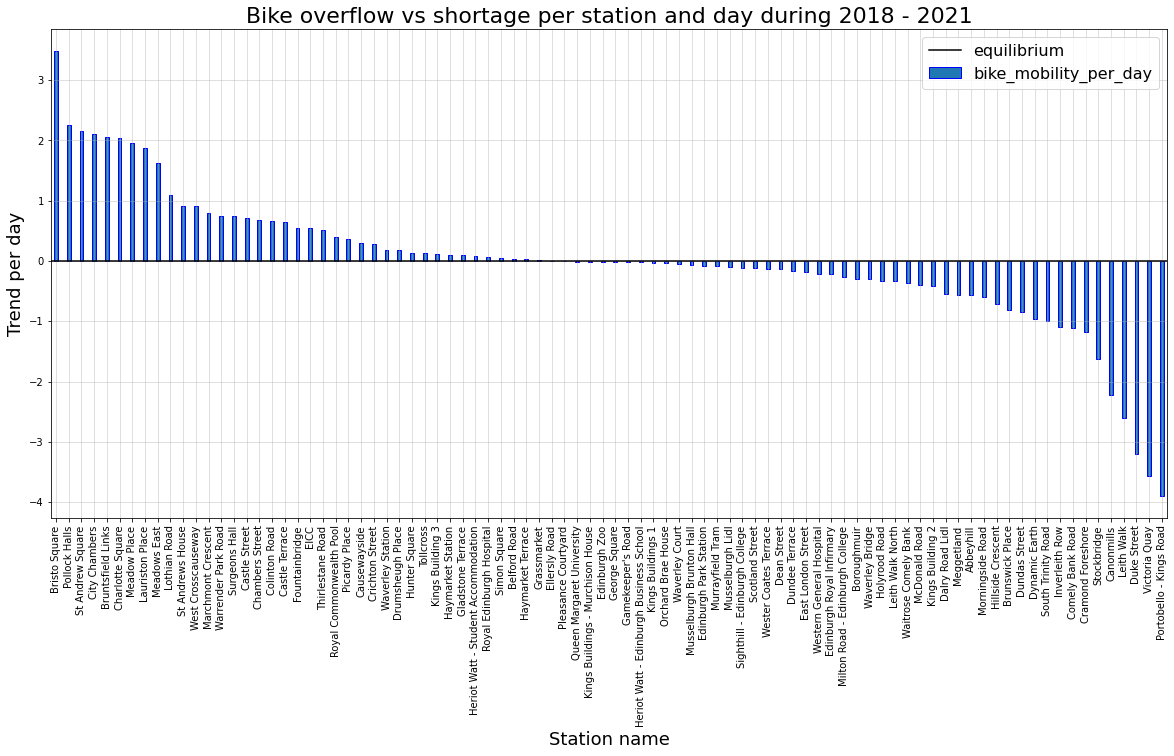

In [344]:
# Visualisation of bike mobility (overflow vs shortage) per day

fig, ax = plt.subplots(figsize = (20,9))
df_mobility.sort_values("bike_mobility_per_day", ascending = False).set_index("station_name")["bike_mobility_per_day"].plot.bar(
    ax = ax, 
    edgecolor = "blue",
    linewidth=1,
    width=0.3
    )

ax.set_title("Bike overflow vs shortage per station and day during 2018 - 2021", fontsize=22)
ax.set_xlabel("Station name", fontsize=18)
ax.set_ylabel("Trend per day", fontsize=18)
ax.axhline(0, color="black", label="equilibrium") # rentals == returns
ax.legend(bbox_to_anchor=(1.,1.), fontsize=16)
ax.grid(alpha=0.5)

plt.show()

## Distance in km between stations

In [345]:
df_locations = df_mobility.merge(df_active.groupby("start_station_name")[["start_station_longitude", "start_station_latitude"]].mean().reset_index().rename(columns = {"start_station_name" : "station_name", "start_station_longitude" : "longitude", "start_station_latitude" : "latitude"}))

df_array = df_locations[["latitude", "longitude"]].to_numpy()
dist_mat = squareform(pdist(df_array,metric=haversine))
df_distance_matrix = pd.DataFrame(dist_mat, columns = df_locations["station_name"], index = df_locations["station_name"])

df_distance_matrix = df_distance_matrix.round(2)

# df_distance_matrix.loc["Bristo Square", "City Chambers"] # Testing
np.fill_diagonal(df_distance_matrix.values, np.nan) 

df_distance_matrix["closest_station"] = df_distance_matrix.loc[df_distance_matrix.index, df_distance_matrix.columns].idxmin()
df_distance_matrix["distance_to_closest_station_in_km"] = df_distance_matrix.loc[df_distance_matrix.index, df_distance_matrix.columns].min()

# generating a new column for each station - closest station and distance
df_locations = df_locations.set_index("station_name").join(df_distance_matrix[["closest_station", "distance_to_closest_station_in_km"]])

df_distance_matrix

station_name,Bristo Square,Pollock Halls,St Andrew Square,City Chambers,Bruntsfield Links,Charlotte Square,Meadow Place,Lauriston Place,Meadows East,Lothian Road,...,Comely Bank Road,Cramond Foreshore,Stockbridge,Canonmills,Leith Walk,Duke Street,Victoria Quay,Portobello - Kings Road,closest_station,distance_to_closest_station_in_km
station_name,,,,,,,,,,,,,,,,,,,,,
Bristo Square,NaN,1.25,1.03,0.48,1.46,1.34,0.72,0.53,0.78,1.06,...,2.24,7.92,1.85,1.94,2.26,2.90,3.65,4.59,Crichton Street,0.18
Pollock Halls,1.25,NaN,2.10,1.61,2.19,2.59,1.43,1.68,0.69,2.27,...,3.48,9.17,3.06,2.96,2.80,3.23,4.18,3.87,Royal Commonwealth Pool,0.18
St Andrew Square,1.03,2.10,NaN,0.55,2.16,0.95,1.63,1.16,1.78,1.17,...,1.53,7.29,1.05,0.91,1.50,2.21,2.77,4.63,Waverley Bridge,0.36
City Chambers,0.48,1.61,0.55,NaN,1.76,1.08,1.13,0.74,1.24,1.01,...,1.89,7.63,1.45,1.46,1.86,2.54,3.22,4.56,Hunter Square,0.16
Bruntsfield Links,1.46,2.19,2.16,1.76,NaN,1.69,0.81,1.02,1.51,1.14,...,2.54,7.56,2.39,2.92,3.62,4.30,4.93,5.95,Thirlestane Road,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Canonmills,1.94,2.96,0.91,1.46,2.92,1.34,2.51,2.01,2.69,1.81,...,1.26,6.77,0.87,NaN,1.25,1.93,2.15,4.88,Scotland Street,0.27
Leith Walk,2.26,2.80,1.50,1.86,3.62,2.36,2.98,2.59,2.83,2.67,...,2.51,7.89,2.08,1.25,NaN,0.72,1.41,3.72,Leith Walk North,0.37
Duke Street,2.90,3.23,2.21,2.54,4.30,3.09,3.62,3.27,3.38,3.39,...,3.19,8.38,2.79,1.93,0.72,NaN,1.04,3.29,Leith Walk North,0.4


## Map visualisation

In [346]:
df_map = df_locations.reset_index().sort_values(by='num_of_rentals_per_day', ascending=False).rename(
    columns = {'num_of_rentals_per_day' : 'Bike rentals per day',
              'num_of_returns_per_day' : 'Bike returns per day'})

fig = px.scatter_mapbox(df_map,lat='latitude', 
                        lon='longitude', 
                        color = 'Bike rentals per day', 
                        zoom=11, 
                        height=600, 
                        hover_name='station_name', 
                        hover_data=['Bike rentals per day', 'Bike returns per day', 'closest_station', 'distance_to_closest_station_in_km'], 
                        size="Bike rentals per day", 
                        size_max = 17,
                        color_continuous_scale=px.colors.sequential.Hot)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [347]:
df_map = df_locations.reset_index().sort_values(by='num_of_rentals_per_day', ascending=False)
df_map['bike_overflow_vs_shortage'] = df_map['num_of_rentals_per_day'] - df_map['num_of_returns_per_day']
df_map['bike_overflow_vs_shortage'] = np.where(df_map.bike_overflow_vs_shortage >= 0, "overflow", "shortage")

fig = px.scatter_mapbox(df_map,lat='latitude', 
                        lon='longitude', 
                        color = 'bike_overflow_vs_shortage', 
                        zoom=11, 
                        height=600, 
                        hover_name='station_name', 
                        hover_data=['num_of_rentals_per_day', 'num_of_returns_per_day', 'closest_station', 'distance_to_closest_station_in_km'], 
                        size="num_of_rentals_per_day", 
                        size_max = 17)
fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":1,"t":2,"l":10,"b":100})
fig.show()

print("City center = bike overflow, outskirts = bike shortage")


City center = bike overflow, outskirts = bike shortage


## Rental period distribution - histogram

count     438259.00
mean        1948.84
std         5657.13
min           61.00
25%          624.00
50%         1163.00
75%         2529.00
max      2363348.00
Name: rental_period, dtype: float64


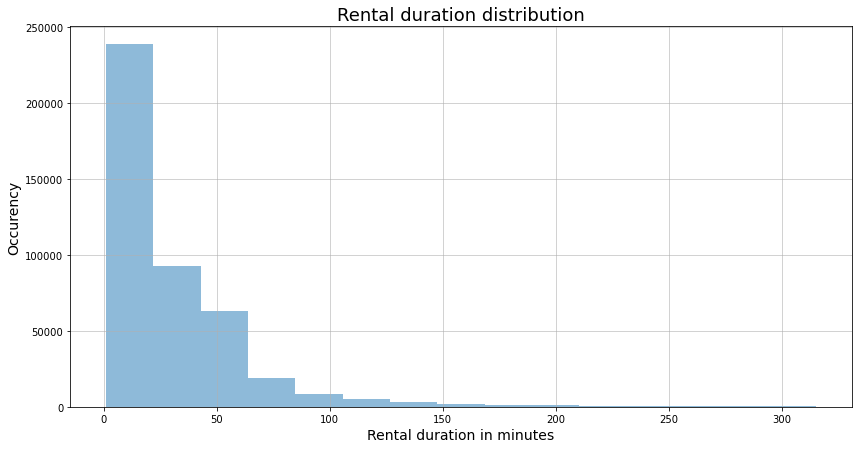

In [348]:
print(df["rental_period"].describe().round(2)) # Especially max value is very far from mean - suggesting outliers in DataFrame

# Due to huge differences in values can´t be histogram (or boxplot) appropriately displayed --> histogram without outliers below:
# outlier : zscore > 3 and zscore < 3

outliers = np.abs(stats.zscore(df["rental_period"])) > 3
df_outliers = df[outliers] # Saving of outliers, if needed

# Outliers temporarily filtered out from df
x = df[~outliers]["rental_period"] / 60 # converting from seconds to minutes

fig, ax = plt.subplots(figsize = (14,7))
ax.hist(x, bins=15, alpha=0.5)
ax.grid(alpha=0.7)
ax.set_xlabel("Rental duration in minutes", fontsize = 14)
ax.set_ylabel("Occurency", fontsize = 14)
ax.set_title("Rental duration distribution", fontsize = 18)
plt.show()

# Distribution is not normal even after removal of outliers, the majority of bike rentals lasts less then hour. 

# Data analysis

In [349]:
# Bike rentals in total per day
df_rentals_per_day = df.groupby("date")["rental_period"].count().reset_index().rename(columns = {"rental_period" : "rentals_per_day"})

# Bike rentals in total per month
df_rentals_per_day["formated_date"] = df_rentals_per_day["date"].dt.strftime("%Y-%m")
df_rentals_per_month = df_rentals_per_day.drop("date", axis = 1)
df_rentals_per_month = df_rentals_per_month.groupby("formated_date").sum().reset_index().rename(columns = {"rentals_per_day" : "rentals_per_month", "formated_date" : "date"})

condition = df_rentals_per_month["date"] == "2018-09" # First month is not complete - shoult be filtered out
df_rentals_per_month = df_rentals_per_month[~condition] 

# Visualisation - bike rentals per month

chart1 = alt.Chart(df_rentals_per_month).mark_line(opacity=0.6).encode(
    x = alt.X(
        "date", 
        axis=alt.Axis(title = "Date", labelAngle = -45, labelFontSize=13, titleFontSize=15, titleColor = "grey")),
    y = alt.Y(
        "rentals_per_month",
        axis=alt.Axis(title ="Bike rentals", labelFontSize=13, titleFontSize=15, titleColor = "grey")),
    tooltip= ["date", "rentals_per_month"],
    strokeWidth = alt.value(8)
).properties(
    width = 800,
    title='Bike rentals in 2018 - 2021 per month'
).configure_axis(
    domainWidth=0.8
).interactive()

chart1.configure_title(
    fontSize=20,
    font='Courier',
    align = "center",
    color='gray')

alt.Chart(...)

In [350]:
#### Same for selected stations (later in streamlit)

# Bike rentals in total per day
df_rentals_per_day = df.groupby(["date", "start_station_name"])["rental_period"].count().reset_index().rename(columns = {"rental_period" : "rentals_per_day"})

# Bike rentals in total per month
df_rentals_per_day["formated_date"] = df_rentals_per_day["date"].dt.strftime("%Y-%m")
df_rentals_per_month = df_rentals_per_day.drop("date", axis = 1)
df_rentals_per_month = df_rentals_per_month.groupby(["formated_date", "start_station_name"]).sum().reset_index().rename(columns = {"rentals_per_day" : "rentals_per_month", "formated_date" : "date"})

condition = df_rentals_per_month["date"] == "2018-09" # First month is not complete - shoult be filtered out
df_rentals_per_month = df_rentals_per_month[~condition] 

# Visualisation - bike rentals per month

chart1 = alt.Chart(df_rentals_per_month).mark_line(opacity=0.6).encode(
    x = alt.X(
        "date", 
        axis=alt.Axis(title = "Date", labelAngle = -45, labelFontSize=13, titleFontSize=15, titleColor = "grey")),
    y = alt.Y(
        "rentals_per_month",
        axis=alt.Axis(title ="Bike rentals", labelFontSize=13, titleFontSize=15, titleColor = "grey")),
    color = "start_station_name",
    tooltip= ["date", "rentals_per_month"],
    strokeWidth = alt.value(8)
).properties(
    width = 800,
    title='Bike rentals in 2018 - 2021 per month'
).configure_axis(
    domainWidth=0.8
).interactive()

chart1.configure_title(
    fontSize=20,
    font='Courier',
    align = "center",
    color='gray')

alt.Chart(...)

## Causes of fluctuation in demand

#### Season

In [351]:
# identifikujte příčiny výkyvů poptávky

# Bike rentals in total per day - without grouping per station
df_rentals_per_day = df.groupby("date")["rental_period"].count().reset_index().rename(columns = {"rental_period" : "rentals_per_day"})

# Bike rentals in total per month
df_rentals_per_day["formated_date"] = df_rentals_per_day["date"].dt.strftime("%Y-%m")
df_rentals_per_month = df_rentals_per_day.drop("date", axis = 1)
df_rentals_per_month = df_rentals_per_month.groupby("formated_date").sum().reset_index().rename(columns = {"rentals_per_day" : "rentals_per_month", "formated_date" : "date"})

condition = df_rentals_per_month["date"] == "2018-09" # First month is not complete - shoult be filtered out
df_rentals_per_month = df_rentals_per_month[~condition] 

# Converting to month name and grouping

df_rentals_per_month['month'] = pd.DatetimeIndex(df_rentals_per_month['date']).month
df_rentals_per_month_name = df_rentals_per_month.groupby("month")["rentals_per_month"].mean().astype(int).reset_index().rename(columns = {"rentals_per_month" : "avg_rentals_per_month"})

d = dict(enumerate(calendar.month_name))
df_rentals_per_month_name['month'] = df_rentals_per_month_name['month'].map(d)
df_rentals_per_month_name.index = range(1,13)

df_rentals_per_month_name

chart2 = alt.Chart(df_rentals_per_month_name).mark_line(opacity=0.6).encode(
    x = alt.X(
        "month", 
        sort = None,
        axis=alt.Axis(title = "Month", labelAngle = -45, labelFontSize=13, titleFontSize=15, titleColor = "grey")),
    y = alt.Y(
        "avg_rentals_per_month",
        axis=alt.Axis(title ="Bike rentals", labelFontSize=13, titleFontSize=15, titleColor = "grey")),
    tooltip= ["month", "avg_rentals_per_month"],
    strokeWidth = alt.value(8)
).properties(
    width = 800,
    title='Average bike rentals in 2018 - 2021'
).configure_axis(
    domainWidth=0.8
).interactive()

chart2.configure_title(
    fontSize=20,
    font='Courier',
    align = "center",
    color='gray')



alt.Chart(...)

#### Covid

In [352]:
# loading of covid data - applied country filter in SQL (United Kingdom)
# Data are for whole UK, we do not have covid cases specific for Edinburg

df_covid_UK = pd.read_csv('covid19_UK.csv').dropna() # deleting NaN values in the first row
df_covid_UK["date"] = pd.to_datetime(df_covid_UK["date"]).dt.date.astype("datetime64")

# Merging data; using inner join - covid dataframe has only 487 records - shorter observed period
df_bikes_covid = df_rentals_per_day.drop('formated_date', axis = 1).merge(df_covid_UK, how = 'inner').rename(columns = {"confirmed": "tested_positive", "deaths" : "covid_deaths"})


condition = df_bikes_covid["tested_positive"] >= 0  # Error in dataframe - two negative values in column tested_positive --> filtered out
df_bikes_covid = df_bikes_covid[condition]

# Correlation between rentals per day and covid cases
corr = df_bikes_covid.corr(method ='pearson').round(2).loc[["rentals_per_day"], ["tested_positive", "covid_deaths"]]
        
corr    
# corr.loc["rentals_per_day", "tested_positive"]
# There is a negative relationship between rentals per day and confirmed covid cases (and deaths)

# Hypothesis: During covid cases explosion, more employees worked from home --> decrease in rented bikes
# ! Correlation is not causality


,tested_positive,covid_deaths
rentals_per_day,-0.43,-0.39


In [353]:
# Displaying relationship with scatterplot + regression line

chart3 = alt.Chart(df_bikes_covid).mark_circle(size=60).encode(
    x = alt.X(
        "tested_positive", 
        axis=alt.Axis(title = "Confirmed covid cases", labelAngle = -45, labelFontSize=13, titleFontSize=15, titleColor = "grey")),
    y = alt.Y(
        "rentals_per_day",
        axis=alt.Axis(title ="Bike rentals per day", labelFontSize=13, titleFontSize=15, titleColor = "grey")),
    tooltip= ["date", "rentals_per_day", "tested_positive", "covid_deaths"],
    strokeWidth = alt.value(4)
).properties(
    width = 800,
    title="Relationship between bike rentals and positive covid tests"
)

# Seems like exponential decrease --> fitting an exponential regression

# chart3 + chart3.transform_regression("tested_positive", "rentals_per_day", method = "exp").mark_line(color = "red")

chart_regression_line = chart3.transform_regression("tested_positive", "rentals_per_day", method = "exp").mark_line(color = "red")

# Top level graph object
chart3 = alt.layer(chart3, chart_regression_line).configure_view(
    stroke = "transparent"
).configure_axis(
    domainWidth=0.8
).configure_title(
    fontSize=20,
    font="Courier",
    align = "center",
    color="gray"
).interactive()

chart3.display()

# The relationship seems not to be linear - data suggests high covid values have greater impact on bike rentals (lockdown?).
# Low number of covid cases = large variance in bike rentals - it is obvious that there is a greater influence of season / temperature

alt.LayerChart(...)

#### Weather

In [354]:
# Note: weather functions probably as a mediator variable between season and bike rentals

df_weather = pd.read_csv('edinburgh_weather.csv') # Loading of table containing weather data from Edinburgh

df_weather["vis"] = df_weather["vis"].map({"Excellent" : 4, "Good" : 3, "Average" : 2,"Poor" : 1}) 
df_weather.drop(["feels", "gust", "time"], axis = 1, inplace = True) # One information about wind and temperature is enough, concrete time is for me at the moment also not relevant

for column in df_weather[["rain", "pressure", "temp", "wind"]].columns:
    df_weather[column] = df_weather[column].apply(lambda x: x.split(" ")[0]) # Clearing values from string

for column in df_weather[["humidity","cloud"]].columns:
    df_weather[column] = df_weather[column].apply(lambda x: x.split("%")[0]) 

df_weather = df_weather.astype({"date" : "datetime64", "temp" : "int64", "wind" : "int64", "rain" : "float64", "humidity" : "int64", "cloud" : "int64", "pressure" : "int64"}) # Converting from object 
df_weather_avg = df_weather.groupby("date").mean().round(2).reset_index().rename(columns = {"temp" : "temperature", "rain" : "rain_mm", "wind" : "wind_km/h", "humidity": "humidity_in_pct", "cloud" : "clouds_in_pct", "pressure": "pressure_in_mb", "vis" : "visibility"}) # Grouping by date, calculation of average values per day


df_final = df_bikes_covid.merge(df_weather_avg, how = "inner")
# Problem - when merging these two datasets, we lost valuable information about covid cases 
# Dates do not sufficiently overlap, this is a limit of merging 3 datasets
# Using left join by merging covid data is on my openion not suitable option -- covid appeared in 2019, before that we would have 0 in covid cases which affects correlations etc.

df_weather_final  = df_rentals_per_day.merge(df_weather_avg).drop("formated_date", axis = 1)

In [355]:
# Correlation matrix

correlation_matrix = df_weather_final.corr(method ='pearson').round(2).sort_values("rentals_per_day")[["rentals_per_day"]]
temperature_rentals_correlation = correlation_matrix.loc["temperature", "rentals_per_day"]

print(f"Temperature and number of rented bikes per day seems to be strongly corelated: r = {temperature_rentals_correlation}")
display(correlation_matrix)

Temperature and number of rented bikes per day seems to be strongly corelated: r = 0.53


,rentals_per_day
humidity_in_pct,-0.26
wind_km/h,-0.25
clouds_in_pct,-0.09
rain_mm,-0.07
visibility,0.09
pressure_in_mb,0.15
temperature,0.53
rentals_per_day,1.00


In [356]:
# Selecting only variables with considerable correlations (0.2 > r < 0.2)
# --> humidity, wind and temperature 

columns = ["humidity_in_pct", "wind_km/h", "temperature"]

charts = []
for column in df_weather_final[columns]:  
    charts.append(alt.Chart(df_weather_final).mark_circle(size=60).encode(
        x = alt.X(
            column, 
            axis=alt.Axis(title = column, labelAngle = -45, labelFontSize=13, titleFontSize=15, titleColor = "grey")),
        y = alt.Y(
            "rentals_per_day",
            axis=alt.Axis(title ="Bike rentals per day", labelFontSize=13, titleFontSize=15, titleColor = "grey")),
        tooltip= ["date", "rentals_per_day", column],
        strokeWidth = alt.value(4)
    ).properties(
        width = 800,
        title=f"Relationship between bike rentals and {column}"
    ).configure_axis(
    domainWidth=0.8
).configure_title(
    fontSize=20,
    font='Courier',
    align = "center",
    color='gray').interactive()                 
)

                  
for chart in charts:
    chart.display()
    

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [357]:
charts = []
for column in df_weather_final[columns]:  
    charts.append(alt.Chart(df_weather_final).mark_circle(size=60).encode(
        x = alt.X(
            column, 
            axis=alt.Axis(title = column, labelAngle = -45, labelFontSize=13, titleFontSize=15, titleColor = "grey")),
        y = alt.Y(
            "rentals_per_day",
            axis=alt.Axis(title ="Bike rentals per day", labelFontSize=13, titleFontSize=15, titleColor = "grey")),
        tooltip= ["date", "rentals_per_day", column],
        strokeWidth = alt.value(4)
    ).properties(
        width = 800,
        title=f"Relationship between bike rentals and {column}"
    ))
    for chart in charts:
        chart_regression_line_2 = chart.transform_regression(column, "rentals_per_day", method = "exp").mark_line(color = "red")
        
        alt.layer(chart, chart_regression_line_2).configure_view(
            stroke = "transparent"
        ).configure_axis(
            domainWidth=0.8
        ).configure_title(
            fontSize=20,
            font="Courier",
            align = "center",
            color="gray"
        ).interactive().display()
            

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

#### Business day vs Weekend

In [358]:
# New column - distinction of business day vs weekend

business_days = pd.date_range(df_rentals_per_day["date"].min(), df_rentals_per_day["date"].max(), freq = "B") # Range of dates excluding weekends
df_business_days = pd.DataFrame(business_days).rename(columns = {0: "date"}) # Converting to df

list_of_business_days = df_business_days["date"].tolist()
df_rentals_per_day["day"] = np.where(df_rentals_per_day.date.isin(list_of_business_days), "business day", "weekend")
                        
df_weekday = df_rentals_per_day.groupby("day")[["rentals_per_day"]].mean().round().reset_index()
df_weekday["pct_increase"] = df_weekday[["rentals_per_day"]].pct_change().round(2)

pct_increase = int(df_weekday.loc[1, "pct_increase"] * 100)
print(f"During the weekend, there is an increase of {pct_increase} % rented bikes compared to business day")

During the weekend, there is an increase of 14 % rented bikes compared to business day


In [359]:
chart4 = alt.Chart(df_weekday).mark_bar(opacity=0.6).encode(
    x = alt.X(
        "day", 
        axis=alt.Axis(title = "", labelAngle = 0, labelFontSize=17)),
    y = alt.Y(
        "rentals_per_day",
        axis=alt.Axis(title ="Bike rentals", labelFontSize=17, titleFontSize=17, titleColor = "grey")),
).properties(
    title='Average number of rented bikes during the weekend and business day',
    width = 250
).configure_title(
    fontSize=20,
    font='Courier',
    align = "center",
    color='gray')

chart4

alt.Chart(...)

#### Prediction - bike rentals

In [360]:
# New columns for prediction purposes - month number and disctinction of business day / weekend

df_final["month_number"] = pd.DatetimeIndex(df_final['date']).month

business_days = pd.date_range(df_final["date"].min(), df_final["date"].max(), freq = "B") # Range of dates excluding weekends
df_business_days = pd.DataFrame(business_days).rename(columns = {0: "date"}) # Converting to df
list_of_business_days = df_business_days["date"].tolist()
df_final["business_day_boolean"] = np.where(df_final.date.isin(list_of_business_days), True, False)
                        
correlation_matrix_final_table = df_final.corr(method ='pearson').round(2).sort_values("rentals_per_day")[["rentals_per_day"]]
correlation_final_temperature_rentals = correlation_matrix_final_table.loc["temperature", "rentals_per_day"]

print(f"Temperature and number of rented bikes per day seems to be even more corelated during covid: r = {correlation_final_temperature_rentals}.")
display(correlation_matrix_final_table)

# Hypothesis: Covid situation is worse during autumn and winther months, when there are also lower temperatures
# -- Covid boom in autumn and winter + low temperature --> stronger correlation between temperature and rentals (dataset contains both information)

Temperature and number of rented bikes per day seems to be even more corelated during covid: r = 0.72.


,rentals_per_day
wind_km/h,-0.34
clouds_in_pct,-0.30
rain_mm,-0.25
covid_deaths,-0.19
business_day_boolean,-0.19
humidity_in_pct,-0.18
tested_positive,-0.11
visibility,0.19
pressure_in_mb,0.28
month_number,0.42


In [361]:
# Regression using train test split
# Using table df_final, where there are all possible predictors
# Disadvantage - when merging above, we are loosing valuable data - (e.g. covid table and weather table do not overlap so much)

# -- Left joining covid table, rentals table and weather table is on my openion not a suitable option, 
# --resulting e.g. in lower correlation between covid and bike rentals (when filling covid cases with 0) 
# -- Covid appeared no sooner then in 2019 --

# By using these selected columns the explanatory power seems to be the highest

reg_cols = ["rentals_per_day", "tested_positive", "covid_deaths", "temperature","humidity_in_pct","wind_km/h", "rain_mm", "month_number", "business_day_boolean"]
df_train, df_test = train_test_split(df_final[reg_cols], train_size=0.7, test_size=0.3, random_state=100)

y_train = df_train.pop('rentals_per_day')
x_train = df_train

y_test = df_test.pop('rentals_per_day')
x_test = df_test

## scaling and training
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_train_df = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)

reg = linear_model.LinearRegression()
reg.fit(x_train_df, y_train)

## scaling test and predict

x_test_scaled = scaler.transform(x_test)
x_test_df = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)

predicted = reg.predict(x_test_df)

predicted = pd.Series(predicted)
y_test = y_test.reset_index().drop(columns='index')
comparison = pd.concat([predicted, y_test], axis=1)

In [362]:
display("Mean squared error: %.2f" % mean_squared_error(y_test, predicted))
display("R2 Coefficient: %.2f" % r2_score(y_test, predicted))

'Mean squared error: 49336.30'

'R2 Coefficient: 0.69'

In [363]:
# Prediction with examlple bellow, in streamlit the user chooses values

example = [2400,30,20,65,15,0.5,1,1]
regressor_prep = pd.DataFrame(example, index=x_test.columns).T
reg_prep_scaled = pd.DataFrame(scaler.transform(regressor_prep), columns=x_test.columns)
reg_prep_scaled

,tested_positive,covid_deaths,temperature,humidity_in_pct,wind_km/h,rain_mm,month_number,business_day_boolean
0,-0.215175,-0.503061,2.444026,-2.003478,-0.103046,0.042893,-1.758092,0.64365


In [364]:
final_prediction = reg.predict(reg_prep_scaled).round()

In [365]:
print(f"Given these conditions, {int(final_prediction)} bikes would be rented on such day.")

Given these conditions, 1699 bikes would be rented on such day.
